# Quantum Enhanced Reinforcement Learning

Code author: Simone Caldarella

The following notebook is a code implementation of the setting described in the [work](https://www.nature.com/articles/s41586-021-03242-7) by Saggio et al.
It is intended as the final project of the course of Quantum Machine Learning held by professor D. Pastorello at University of Trento.

## Imports

Nothing fancy to see here, just the library and modules required. We will made heavy use of [Qiskit](https://qiskit.org/), which is a library specifically designed for Quantum Algorithms, which allows to design and test any algorithms in which quantum information is involved.

In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

from tqdm import tqdm

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, execute, QuantumCircuit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit.extensions.unitary import UnitaryGate

# import basic plot tools
from qiskit.visualization import plot_histogram, array_to_latex

## Definition of the Agent

Despite a reinforcement learning agent by itself is fairly more complex, here we are not focusing on a real life agent. Instead our focus is on how being "quantum-aware" can help its learning process. In the paper all the set of actions is mapped into a 2-dim space (win vs lose), thus we don't directly care about the specific action the agent want to perform, but instead on the binary relaxation of the problem (wether it choose a win or a lose action).

For the above reason the agent is simply designed in such a way that it is composed of an ```epsilon``` which indicates the current winning probability (i.e. the sum of the probabilities of all its winning actions/routes) and a ```reward_count```, which is simply used as a parameter to update its policy (```epsilon```).

In [2]:
class Agent:
    
    def __init__(self, epsilon):
        self.reward_count = 0
        self.epsilon = epsilon
        
    def get_reward(self):
        self.reward_count += 1
        self.epsilon = (1+2*self.reward_count)/(100+2*self.reward_count)

## Definition of the Environment

The environment should allows the agent to choose for an available action, update its current probability wether a quantum epoch is choosen and obtain a reward.

To briefly explain the code above:
- in the ```__init__``` the circuit if initialized and some parameters are choosen (```combined_strategy_thresh``` is the threshold on which the agent should stop to use the quantum strategy in order to optimize its overall performance)
- in the ```combined_strategy``` the agent perform one quantum epoch and one classical epoch if its epsilon is below the ```combined_strategy_thresh```, otherwise it perform two classical epoch
- the ```classical_strategy``` simply performs a sampling in the event space ```{"win": p("win") = epsilon, "lose": p("lose") = 1-epsilon)``` and if ```"win"``` is selected then the agent receive a reward
- the ```quantum_strategy``` is similar to the ```combined_strategy``` with the difference that it has no switching into classical strategy, thus it degradates after having reaching the probability peak due to oscillating (sin(theta)) behaviour of the Grover Diffusion over time
- the methods ```init_circuit``` and ```diffusion``` serves to create the quantum circuit that gets the statevector in the form of |psi> = sqrt(p(win))\*|1> + sqrt(p(lose))\*|0>:
    - basically the statevector is initialized using epsilon as p(win) and 1-epsilon as p(lose)
    - the diffusion circuit of the grover algorithm is implemented using a z gate (which simply invert the phase of the win cubit z(sqrt(epsilon)|1>) = -sqrt(epsilon)|1>) and a Unitary Operator which simply is a Density Matrix initialized with the expression of the reflection -> 2|psi><psi|-I 

In [3]:
class World:
    
    def __init__(self, initial_epsilon, combined_strategy_thresh=0.396):
        self.initial_epsilon = initial_epsilon
        self.circuit = self.init_circuit(initial_epsilon)
        self.combined_strategy_thresh = combined_strategy_thresh
        self.stop_quantum = False
        
    def combined_strategy(self, agent):
        epsilon = agent.epsilon
        reward_one = None

        if not self.stop_quantum:
            new_epsilon = self.quantum_epoch(epsilon)
        else:
            epsilon = agent.epsilon
            reward_one = self.classical_epoch(epsilon)
            if reward_one == 1:
                agent.get_reward()
            new_epsilon = epsilon
            
        reward_two = self.classical_epoch(new_epsilon)
        if reward_two == 1:
            agent.get_reward()
            
        if agent.epsilon > self.combined_strategy_thresh:
            self.stop_quantum = True
        
        if reward_one:
            return [reward_one, reward_two]
        else:
            return [reward_two/2, reward_two/2]
    
    def classical_strategy(self, agent):
        reward_one= self.classical_epoch(agent.epsilon)
        if reward_one == 1:
            agent.get_reward()
        
        reward_two = self.classical_epoch(agent.epsilon)
        if reward_two == 1:
            agent.get_reward()
        
        return [reward_one, reward_two]
    
    def quantum_strategy(self, agent):
        new_epsilon = self.quantum_epoch(agent.epsilon)
        reward = self.classical_epoch(new_epsilon)
        if reward == 1:
            agent.get_reward()
        return [reward/2, reward/2]
    
    def classical_epoch(self, epsilon):
        return np.random.choice(np.arange(0, 2), p = [1-epsilon, epsilon])
    
    def quantum_epoch(self, epsilon):
        self.circuit = self.init_circuit(epsilon)
        new_epsilon = Statevector.from_instruction(self.circuit).data.real[1]**2
        return new_epsilon
        
    def init_circuit(self, epsilon):
        circuit = QuantumCircuit(1)
        circuit.initialize([math.sqrt(1-epsilon), math.sqrt(epsilon)], 0)
        circuit.z(0)
        circuit.append(self.diffusion(epsilon), [0])
        return circuit
    
    def diffusion(self, epsilon):
        a = Statevector([math.sqrt(1-epsilon), 
                         math.sqrt(epsilon)])
        density = DensityMatrix(2*np.outer(a, a)-np.identity(2))
        c = UnitaryGate(density)
        return c

## Experiment

This is the boring part. It is a class used to manage the experiment. You can select the number of agents to be used, the initial winning probability, the number of epochs, the strategies to use and the combined strategy threshold (all the default values are given by the paper and represents the optimal value they used for the experiments).

After having performed the experiments, the plots of the results (which represents the average reward obtained by the ```n_agents``` at each even epoch) are saved as png in the same folder that contains this notebook

In [4]:
class Experiment:
    
    def __init__(self, 
                 n_agents=1024, 
                 initial_epsilon=1/100, 
                 epochs=400, 
                 combined_strategy_thresh=0.396, 
                 strategies=None):
        
        self.n_agents = n_agents
        self.initial_epsilon = initial_epsilon
        self.epochs = epochs
        self.combined_strategy_thresh = combined_strategy_thresh
        self.strategies = ["combined"] if not strategies else strategies
        
        self.logs_reward = {strategy: np.zeros((n_agents, epochs)) 
                            for strategy in self.strategies}
        self.logs_epsilon = {strategy: np.zeros((n_agents, epochs)) 
                            for strategy in self.strategies}
        
    def perform_complete_experiment(self):
        for strategy in self.strategies:
            print(f"Starting {strategy}")
            for agent in tqdm(range(self.n_agents)):
                self.perform_single_run(agent, strategy)
                
        
    def perform_single_run(self, agent_num, strategy):
        agent = Agent(epsilon = self.initial_epsilon)
        world = World(agent.epsilon, self.combined_strategy_thresh)

        for e in range(self.epochs):
            if strategy == "quantum":
                r = world.quantum_strategy(agent)
                    
            elif strategy == "classical":
                r = world.classical_strategy(agent)
            
            elif strategy == "combined":
                r = world.combined_strategy(agent)
            
            else:
                raise NotImplementedError
                
            self.logs_reward[strategy][agent_num, e] = r[1]
            self.logs_epsilon[strategy][agent_num, e] = agent.epsilon
            
    def plot_results(self):
        for strategy, color in self.strategies.items():
            rewards = self.logs_reward[strategy].mean(axis=0)
            plt.plot(rewards, label=strategy, color=color, alpha=0.3, linewidth=2)
            plt.scatter(list(range(len(rewards))), rewards, color=color, s=10, marker=".")
            
        plt.legend()
        plt.set_title(f"Average rewards(n={self.n_agents}) over epochs")
        plt.savefig(f"results__n_agents={self.n_agents}__thresh_combined={self.combined_strategy_thresh}.pdf")

In [5]:
ex1 = Experiment(strategies={"classical": "orangered", "quantum": "royalblue", "combined": "green"}, n_agents=256, epochs=500)
ex1.perform_complete_experiment()

Starting classical


100%|██████████| 256/256 [00:02<00:00, 123.35it/s]


Starting quantum


100%|██████████| 256/256 [00:57<00:00,  4.42it/s]


Starting combined


100%|██████████| 256/256 [00:08<00:00, 31.17it/s]


In [6]:
ex2 = Experiment(strategies={"classical": "orangered", "quantum": "royalblue", "combined": "green"}, n_agents=10000, epochs=500)
ex2.perform_complete_experiment()

Starting classical


100%|██████████| 10000/10000 [06:00<00:00, 27.71it/s]


Starting quantum


100%|██████████| 10000/10000 [45:11<00:00,  3.69it/s] 


Starting combined


100%|██████████| 10000/10000 [05:12<00:00, 31.95it/s]


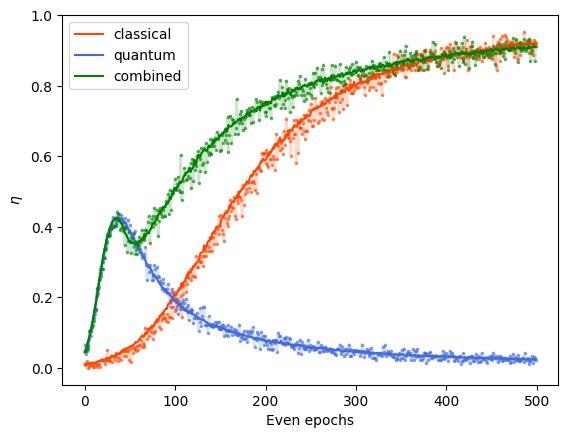

In [15]:
for strategy, color in ex1.strategies.items():
    rewards = ex1.logs_reward[strategy].mean(axis=0)
    plt.plot(rewards, color=color, alpha=0.2, linewidth=2)
    plt.scatter(list(range(len(rewards))), rewards, color=color, s=10, marker=".", alpha=0.5)
    if ex2:
        rewards2 = ex2.logs_reward[strategy].mean(axis=0)
        plt.plot(rewards2, color=color, label=strategy, linewidth=1.5, alpha=1)

plt.xlabel("Even epochs")
plt.ylabel("$\\eta$")
plt.legend()
plt.savefig("strategies.pdf")
